# Topological Data Analysis

Обзор взаимодействий между стандартной библиотекой `sklearn`и библиотеками `ripser` и `persim` для топологического анализа данных на конкретных примерах.

In [1]:
# !pip install ripser
# !pip install persim

In [2]:
from ripser import ripser
from ripser import Rips
import persim
from persim import PersImage
from persim import plot_diagrams 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn import datasets
from math import ceil
import time

# Import packages for loading .mat files
import os 
from os.path import dirname, join as pjoin
import scipy.io as sio

## Clustering Algorithms

*Кластеризация* данных является основной задачей в обучении без учителя. В данном notebook рассмотрены такие методы как k-Means, DBSCAN, которые делят данные на кластеры и требуют настройки параметров. Но при разбиении на кластеры, данные метода потенциально игнорируют более тонкую структуру кластеров.

*Иерархическая кластеризация* создает многоуровневую сводку структуры кластера, визуализируемую в виде дендрограммы.


Посмотрим производительность некоторых алгоритмов кластеризации на наборе "игрушечных" данных. 

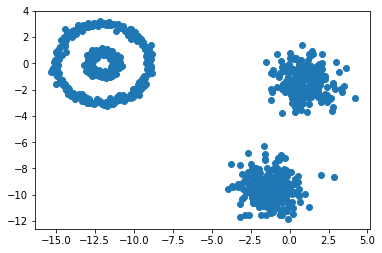

In [3]:
# Import packages for creating toy datasets and plotting
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs

# Create two datasets using above functions
X1, y1 = make_circles(n_samples=500, noise = 0.05, factor=0.3, random_state = 3)
X2, y2 = make_blobs(n_samples=500, centers=2, center_box = (-10,10), random_state=2)

# Combine the toy datasets. The first one is scaled and translated.
X = np.concatenate((3*X1-np.array([[12,0]]),X2),axis=0)

# Plot the result
plt.scatter(X[:,0],X[:,1]);

### $k$-Means Clustering

Один из самых основных алгоритмов кластеризации - **𝑘-Means**. Функция включена в `scikit-learn`. Для запуска 𝑘-Means нужно выбрать 𝑘. 

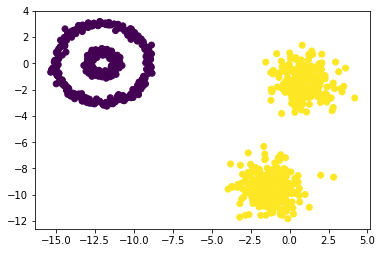

In [4]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2).fit(X) # Choose 2 clusters to start

plt.scatter(X[:,0],X[:,1],c = kmeans.labels_);

Видно, что это неправильный выбор

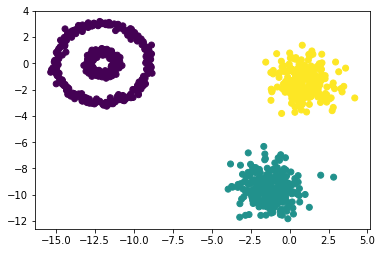

In [5]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3).fit(X) 

plt.scatter(X[:,0],X[:,1],c = kmeans.labels_);

с 3 кластерами больше похоже на правду, но все еще не оптимально

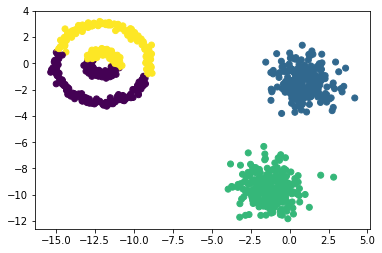

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4).fit(X) 

plt.scatter(X[:,0],X[:,1],c = kmeans.labels_);

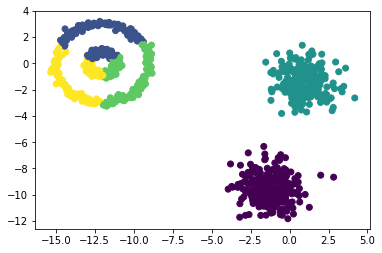

In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5).fit(X) 

plt.scatter(X[:,0],X[:,1],c = kmeans.labels_);

Независимо от того, сколько кластеров мы выберем, 𝑘-Means не сможет разделить концентрические круги.

### DBSCAN

Другой популярный алгоритм класстеризации - **DBSCAN**. DBSCAN выбирает количество кластеров на основе данных. Здесь можно выбрать различные параметры - eps и min_samples, которые сильно влияют на производительность алгоритма.

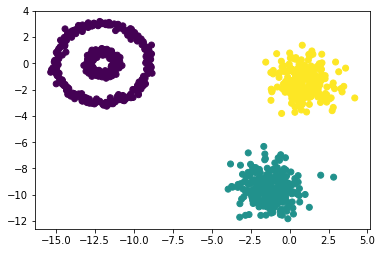

In [8]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps = 2, min_samples=5).fit(X)
plt.scatter( X[:,0], X[:,1], c=dbscan.labels_ );

Если мы настроим параметры правильно, DBSCAN сможет разделить концентрические окружности.

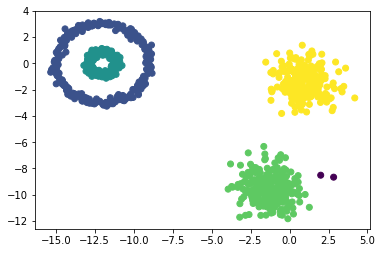

In [9]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps = 1, min_samples=5).fit(X)
plt.scatter( X[:,0], X[:,1], c=dbscan.labels_ );

Все эти алгоритмы кластеризации предоставляют данные на выходе как помеченные подмножества. Из-за этого можно упустить поведение кластеризации «более мелкого масштаба».

### Hierarchical Clustering

Существует еще один стиль алгоритма кластеризации, называемый **иерархической кластеризацией**, который создает сводную информацию о поведении кластеров во всех масштабах. Вывод здесь можно рассматривать как *дендрограмму*.

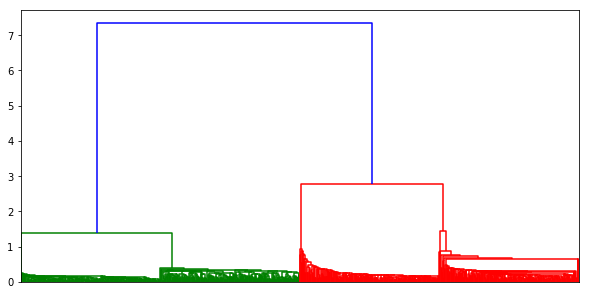

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage  

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
linked = linkage(X, 'single')
dendrogram(linked, labels = None, show_leaf_counts=False)
ax.set_xticklabels([]);

Выше показано, что есть несколько кластеров в наибольшем масштабе. Каждый из них состоит из двух кластеров в меньшем масштабе. Ниже этого есть много очень нечетких групп, которые могут быть прочитаны как «шум».

Метки для точек могут быть извлечены из дендрограммы с помощью алгоритма агломерационной кластеризации. Как и 𝑘-Means функция требует от нас выбрать несколько кластеров. Разница лишь в том, что теперь мы можем сделать очень обоснованное предположение, используя дендрограмму в качестве руководства.

Мы можем увидеть два самых больших кластера:

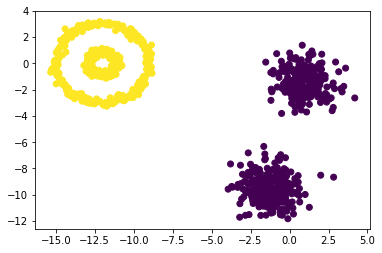

In [11]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=2, linkage = 'single')
ac.fit(X)
plt.scatter(X[:,0],X[:,1],c=ac.labels_);

или 4 самых больших кластера:

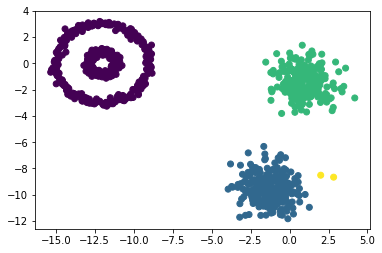

In [12]:
ac = AgglomerativeClustering(n_clusters=4, linkage = 'single')
ac.fit(X)
plt.scatter(X[:,0],X[:,1],c=ac.labels_);

или 5 самых больших кластеров, которые выглядят как выходные данные **DBSCAN**:

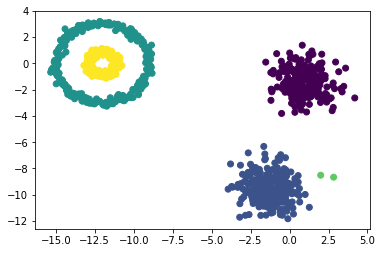

In [13]:
ac = AgglomerativeClustering(n_clusters=5, linkage = 'single')
ac.fit(X)
plt.scatter(X[:,0],X[:,1],c=ac.labels_);

или сколько угодно кластеров, что мы захотим, которые будут собирать все более точную информацию:

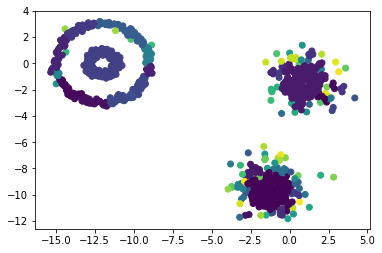

In [14]:
ac = AgglomerativeClustering(n_clusters=100, linkage = 'single')
ac.fit(X)
plt.scatter(X[:,0],X[:,1],c=ac.labels_);

__________________________________________

# Computing Persistence Diagrams

Основная топологическая особенность, которая используется в TDA, называется **persistence diagram**. В этом примере мы вычисляем persistence diagram для нескольких облаков точек. Для этого будут использоваться специализированные пакеты Python для TDA: `ripser` и `persim`

In [15]:
# Import packages
from ripser import ripser
# ripser - пакет для вычисления Barcodes из Vietoris-Rips
from persim import plot_diagrams 
# persim - это пакет для отображения и вычисления расстояний между persistence diagram

# Теория о TDA


 - ##  Betti numbers

Каждому пространству X можно сопоставить векторное пространство $H_{k}(X)$, так называемое векторное пространство *k*-й гомологии X. Его размерность $β_{k}(X)$ называется ***k*-м числом Бетти X**.

Числа Бетти $β_{k}(X)$ считают «*k*-мерные дыры» в X:
 - 0-мерный - количество соединенных частей
 - 1-мерный - количество незаполненных петель
 - 2-мерная - количество незаполненных "пустот"
 - k-мерная - четко определенная концепция, которую мы не можем визуализировать
 
**Пример:**

<img  src = "betti.png">


Вычисление гомологии $H_{k}(X)$ соответствует вычислению чисел Бетти, где Х - симплексиальный комплекс:
 - $H_{0}(X)$ -> $β_{0}(X)$
 - $H_{1}(X)$ -> $β_{1}(X)$
 - $H_{2}(X)$ -> $β_{2}(X)$

## Persistent homology

Отслеживание «рождения» и «смерти» топологических особенностей («дыр» различных размеров) необходимо для того, чтобы создать **barcode plot** или **persistent диаграмму** для X. *Persistent homology* ("долгоживущая гомология") - один из главных инструментов в TDA.

 #### Пример:
 
<img src = "example.png">

#### Еще пример:

<img width="700px" src = "birth-death.png">

**Слева:** *Barcode Plot* 

Каждая горизонтальная полоса показывает время жизни топологического признака как функцию ε для группы гомологий $H_{0}$, $H_{1}$, $H_{2}$. Существенными особенностями являются длинные горизонтельные  столбики. 

**Справа:** *Persistence Diagram*

Точки на диаграмме постоянства находятся во взаимно однозначном соответствии с полосами на графике Barcode. Рождение и
время смерти barcode становятся x- и y-координатами persistence диаграммы. Существенные особенности далеки от
диагонали.

### Random Point Cloud 

Начнем с рандомного набора данных. Давайте просто возьмем несколько случайных точек на плоскости (облако из 100 точек).

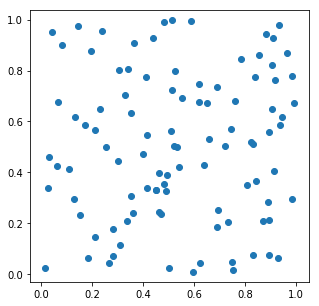

In [16]:
data = np.random.random((100,2)) 
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1]) 
ax.axis('equal'); 

Теперь мы вычисляем persistent homology dataset'а. Это делается путем применения функции `ripser`. Ripser имеет множество опций, такие как диапазон вычисляемых измерений, тип данных и т.д.

In [17]:
ripserData = ripser(data)

In [18]:
ripserData

{'dgms': [array([[0.        , 0.00096012],
         [0.        , 0.01137125],
         [0.        , 0.01172367],
         [0.        , 0.01218594],
         [0.        , 0.02311433],
         [0.        , 0.02815368],
         [0.        , 0.02846026],
         [0.        , 0.03059553],
         [0.        , 0.03074471],
         [0.        , 0.03112473],
         [0.        , 0.03259569],
         [0.        , 0.03296541],
         [0.        , 0.03323134],
         [0.        , 0.03550242],
         [0.        , 0.03557582],
         [0.        , 0.03725544],
         [0.        , 0.03740082],
         [0.        , 0.03760434],
         [0.        , 0.04017795],
         [0.        , 0.04052531],
         [0.        , 0.0410591 ],
         [0.        , 0.04224856],
         [0.        , 0.04613212],
         [0.        , 0.04839825],
         [0.        , 0.04865787],
         [0.        , 0.05022991],
         [0.        , 0.05043335],
         [0.        , 0.0504754 ],
         [0.

Все «ключи» ripser'a:

In [19]:
ripserData.keys()

dict_keys(['dgms', 'cocycles', 'num_edges', 'dperm2all', 'idx_perm', 'r_cover'])

Вычисления, которые нас действительно волнуют, находятся под ключом 'dgms':

In [20]:
diagrams = ripser(data, maxdim=2)['dgms']
print(diagrams) 

[array([[0.        , 0.00096012],
       [0.        , 0.01137125],
       [0.        , 0.01172367],
       [0.        , 0.01218594],
       [0.        , 0.02311433],
       [0.        , 0.02815368],
       [0.        , 0.02846026],
       [0.        , 0.03059553],
       [0.        , 0.03074471],
       [0.        , 0.03112473],
       [0.        , 0.03259569],
       [0.        , 0.03296541],
       [0.        , 0.03323134],
       [0.        , 0.03550242],
       [0.        , 0.03557582],
       [0.        , 0.03725544],
       [0.        , 0.03740082],
       [0.        , 0.03760434],
       [0.        , 0.04017795],
       [0.        , 0.04052531],
       [0.        , 0.0410591 ],
       [0.        , 0.04224856],
       [0.        , 0.04613212],
       [0.        , 0.04839825],
       [0.        , 0.04865787],
       [0.        , 0.05022991],
       [0.        , 0.05043335],
       [0.        , 0.0504754 ],
       [0.        , 0.05244847],
       [0.        , 0.05328089],
       [0

Мы видим, что выходные данные диаграмм представляют собой пару массивов. Это точки на persistence диаграмме для persistence гомологий степени 0 и степени 1 соответственно. Теперь мы можем построить эти диаграммы. Это можно сделать на разных осях или на одной оси.

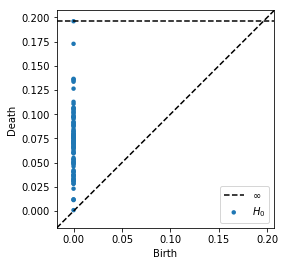

In [21]:
plot_diagrams(diagrams[0]) # Just degree-0

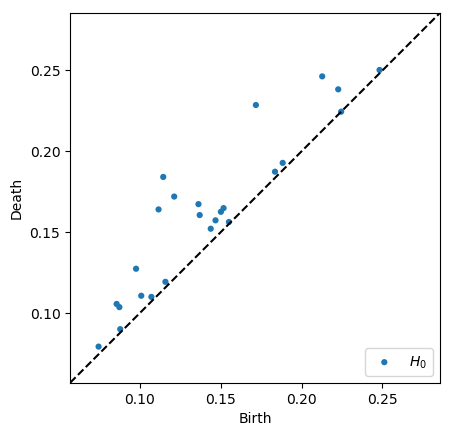

In [22]:
plot_diagrams(diagrams[1]) # Just degree-1

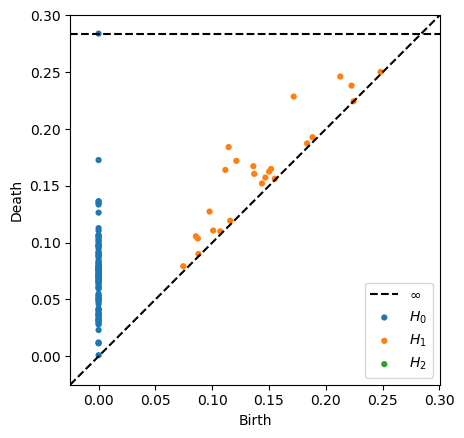

In [23]:
plot_diagrams(diagrams) # Both degree-0 and degree-1

### Circles and Blobs 

Применяя persistent homology к набору данных из примера в самом начале, мы наблюдаем многоуровневую кластерную структуру, а также тот факт, что в данных присутствуют круги.

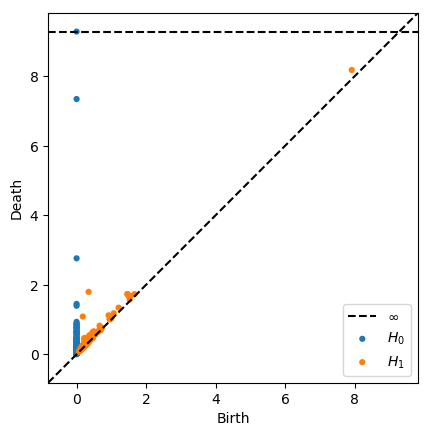

In [24]:
diagrams = ripser(X)['dgms']
plot_diagrams(diagrams)

### Spheres
Давайте рассмотрим персистентную гомологию облаков точек на сферах на плоскости и в трехмерном пространстве.

In [25]:
# Определить функцию для случайной выборки из сферы
def sample_spherical(npoints, ndim=3):
    sample = np.random.randn(ndim, npoints)
    sample /= np.linalg.norm(sample, axis=0)
    sample = sample.T
    return sample

# Произвольная выборка из сферы с добавленным шумом
def noisy_sample_spherical(npoints, ndim, noise_level = 0.01):
    sphere = sample_spherical(npoints, ndim)
    noise = np.random.multivariate_normal(ndim*[0], noise_level*np.eye(ndim), npoints)
    sample = sphere + noise
    return sample

Давайте сначала посмотрим на сферу, находящаяся в $\mathbb{R}^2$, иными словами на круг.

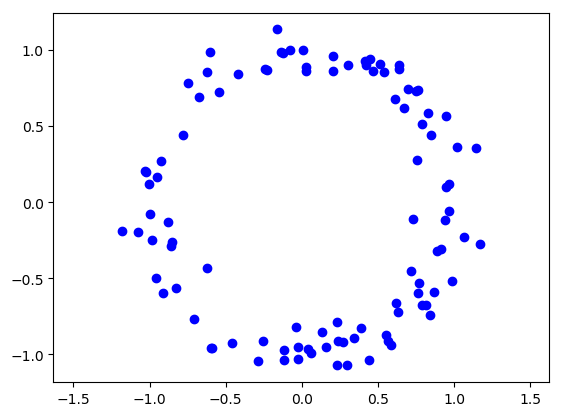

In [26]:
data = noisy_sample_spherical(100,2) # Создаём шумный круг

# Рисуем график данных в виде точечной диаграммы.
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(data[:, 0], data[:, 1], 'ob', label='Source samples');
ax1.axis('equal');

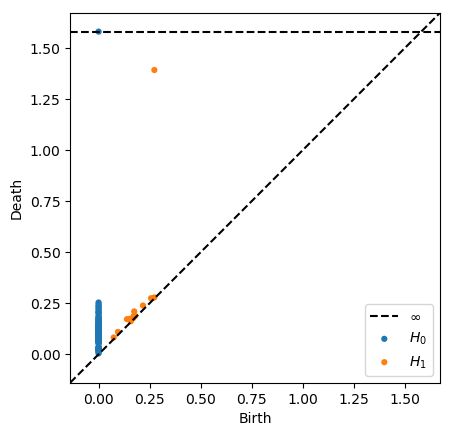

In [27]:
dgms = ripser(data)['dgms']
plot_diagrams(dgms, show=True)

Играя с параметрами, мы можем сделать круг более плотным или более шумным.

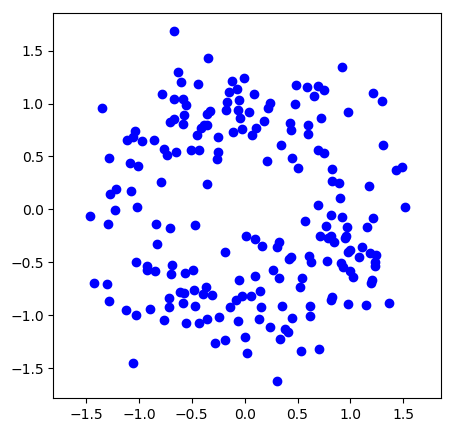

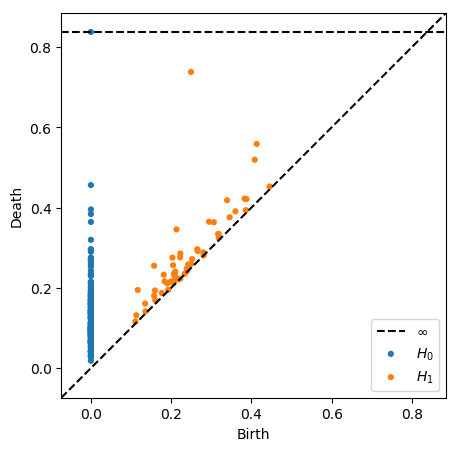

In [28]:
numsamp = 200
noise = .1

data = noisy_sample_spherical(numsamp,ndim=2,noise_level=noise)

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
ax1.plot(data[:, 0], data[:, 1], 'ob');
ax1.axis('equal')
dgms = ripser(data)['dgms']
fig2 = plt.figure(figsize=(5,5))
plot_diagrams(dgms, show=True)

Теперь вычисляем persistence диаграмму для сферы в $\mathbb{R}^3$. Мы можем указать, что хотим вычислить гомологию степени 2. Затем мы строим persistence diagram на тех же осях.

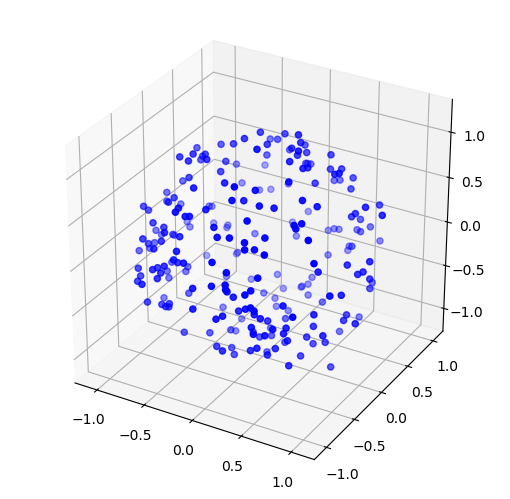

In [29]:
sphere = noisy_sample_spherical(250,3)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(sphere[:,0],sphere[:,1],sphere[:,2], c='b', marker='o');
ax.set_aspect('equal');

In [30]:
sphere[:,0].shape

(250,)

Используя `ripser`, мы вычисляем persistent homology облака точек и строим persistence diagrams: 

Computation Time: 6.728652238845825 seconds


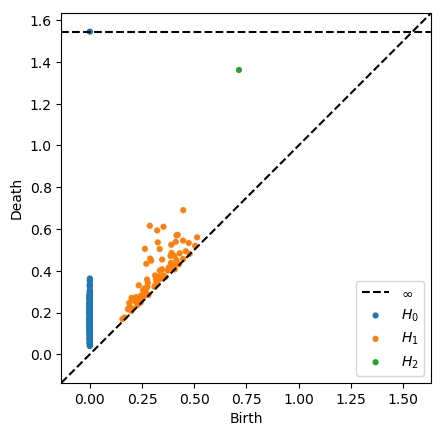

In [31]:
import time

start0 = time.time()
diagrams = ripser(sphere,maxdim=2)['dgms']
plot_diagrams(diagrams)
end0 = time.time()

print('Computation Time: ' + str(end0 - start0) + ' seconds')

Если обратить внимание на persistence диаграмму, то можно заметить, что есть один очень постоянный 0-цикл и один 2-цикл. Они отражают топологию сферы.

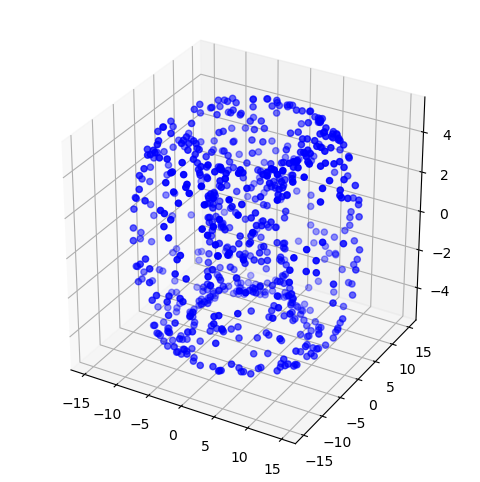

In [32]:
N = 700
r = 5
R = 10

theta = 2*np.pi*np.random.rand(N)
phi = 2*np.pi*np.random.rand(N)
X = (R + r * np.cos(phi)) * np.cos(theta)
Y = (R + r * np.cos(phi)) * np.sin(theta) 
Z = r *  np.sin(phi)
pointCloud = np.append(X.reshape(N,1),Y.reshape(N,1),axis =1)
pointCloud = np.append(pointCloud,Z.reshape(N,1), axis = 1)

fig = plt.figure(figsize = (6,6))
ax = fig.gca(projection='3d', adjustable='box')
ax.scatter(pointCloud[:,0],pointCloud[:,1],pointCloud[:,2], c='b', marker='o');
ax.set_aspect('equal');

# Filtering an Image (Фильтрация изображения)

Этот пример - адаптация приведенного в документации примера для Ripser https://github.com/scikit-tda/ripser.py.

Цель состоит в том, чтобы применить эти методы для изучения изображения крыла стрекозы, доступного по этой <a href = "https://all-free-download.com/free-photos/download/dragonfly-wings_207742.html">ссылке</a>

<img src = "dragonfly_wings.jpg">

Если мы думаем о каждом значении пикселя как о выходе функции, это изображение можно понимать как график поверхности. Если белые пиксели соответствуют большим значениям функции, то мы можем представить, что центр каждой «ячейки» в крыле соответствует локальному максимуму функции. Если мы возьмем минус нашей функции, то каждая ячейка соответствует локальному минимуму.

Цель этого примера - проверить, что персистентная гомология степени 0 фильтрации множества подуровней этого графа выберет эти локальные минимумы как точки с высокой персистентностью.

## Processing the Image (Обработка изображения)

Преобразовываем изображение в истинную градацию серого, а затем сглаживаем его (создаем более гладкий график поверхности).

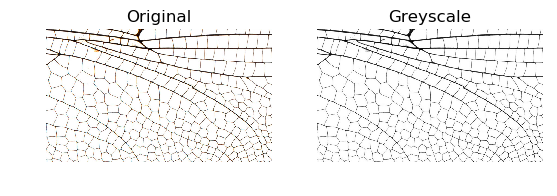

In [33]:
import PIL

wing_original = plt.imread("dragonfly_wings.jpg")
wing_grey = np.asarray(PIL.Image.fromarray(wing_original).convert('L'))

plt.subplot(121)
plt.title('Original')
plt.imshow(wing_original)
plt.axis('off')
plt.subplot(122)
plt.title('Greyscale')
plt.imshow(wing_grey, cmap='gray')
plt.axis('off')
plt.show()

Когда мы сгладим, мы добавим небольшое количество шума к каждому значению пикселя. Эта уловка, чтобы сделать значения пикселей уникальными (далее пригодится при визуализации).

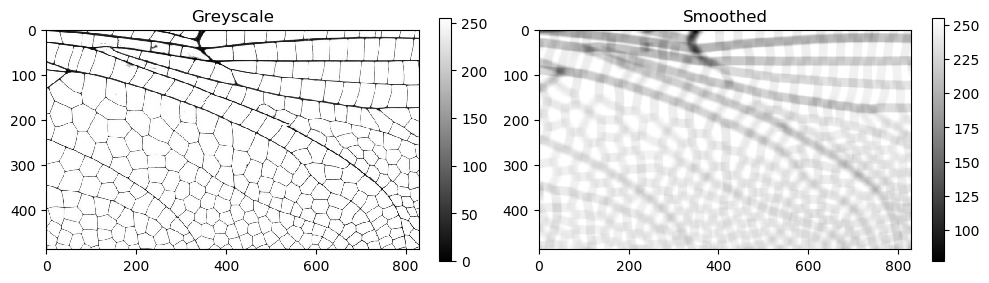

In [34]:
from scipy import ndimage

# Smooth the image using a moving average and add some random noise
smoothed = ndimage.uniform_filter(wing_grey.astype(np.float64), size=20)
smoothed += 0.01 * np.random.randn(*smoothed.shape)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('Greyscale')
im = plt.imshow(wing_grey, cmap='gray')
plt.colorbar(im, fraction=0.03)

plt.subplot(122)
im = plt.imshow(smoothed, cmap='gray')
plt.title('Smoothed')
plt.colorbar(im, fraction=0.03)

plt.tight_layout()
plt.show()

Вычислим фильтрацию подуровня для поверхности изображения. Фильтры суперуровневого набора для данных изображения встроены в `ripser` как `lower_star_img`. Помним, что берём негатив нашей поверхности, чтобы белые пиксели были локальными минимумами.

Persistence диаграмма отображается с «временем рождения» на оси-$x$ и «продолжительностью жизни» на оси-$y$ (время жизни = время смерти - время рождения).

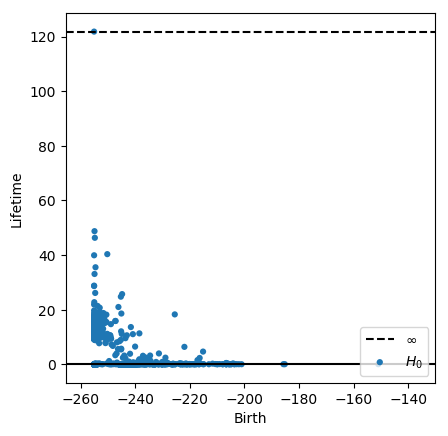

In [35]:
from ripser import lower_star_img

dgm = lower_star_img(-smoothed)
plot_diagrams(dgm, lifetime=True)
plt.show()

Установим порог жизни в 5 лет и нарисуем пиксели, генерирующие классы гомологии поверх исходного изображения:

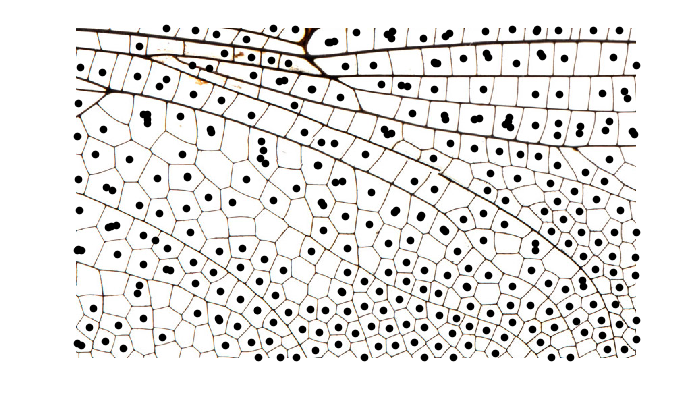

In [36]:
thresh = 5
# Create list of indices up to number of points in persistence diagram
idxs = np.arange(dgm.shape[0])
# Find indices of points with long persistence
idxs = idxs[np.abs(dgm[:, 1] - dgm[:, 0]) > thresh]

# Plot original wing image
plt.figure(figsize=(8, 5))
plt.imshow(wing_original)

# Plot points generating high-persistence points in the diagram
X, Y = np.meshgrid(np.arange(smoothed.shape[1]), np.arange(smoothed.shape[0]))
X = X.flatten()
Y = Y.flatten()
for idx in idxs:
    bidx = np.argmin(np.abs(smoothed + dgm[idx, 0]))
    plt.scatter(X[bidx], Y[bidx], 20, 'k')
plt.axis('off')

plt.show()

Довольно неплохой результат, но не идеальный! Можно поиграть с уровнями шума и пороговыми значениями, чтобы увидеть, можно ли мы получить лучший результат.

# Bottleneck Distance and Shape Classification

### Loading and Exploring the Data

Данные состоят из большого количества плотно выбранных плоских кривых, представляющих различные объекты (кости, собаки, машины и т.д.). Это файл (.mat ) мы читаем с помощью следующих команд:

In [37]:
data_dir = os.getcwd()
mat_fname = pjoin(data_dir, 'planarShapes.mat') 
mat_contents = sio.loadmat(mat_fname) # Read the file

In [38]:
planarShapes = mat_contents['planarShapes']
planarShapes.shape

(2, 100, 1300)

Видно, что *planarShapes* является массивом 2x100x1300. Исследуя больше, мы обнаружим, что существует 1300 отдельных фигур, разделенных на 20 копий похожих фигур (т.е. 65 классов похожих фигур). Каждая из 1300 фигур представляет собой облако точек в $\mathbb{R}^2$, состоящее из 100 точек. Давайте нарисуем пару фигур ниже:

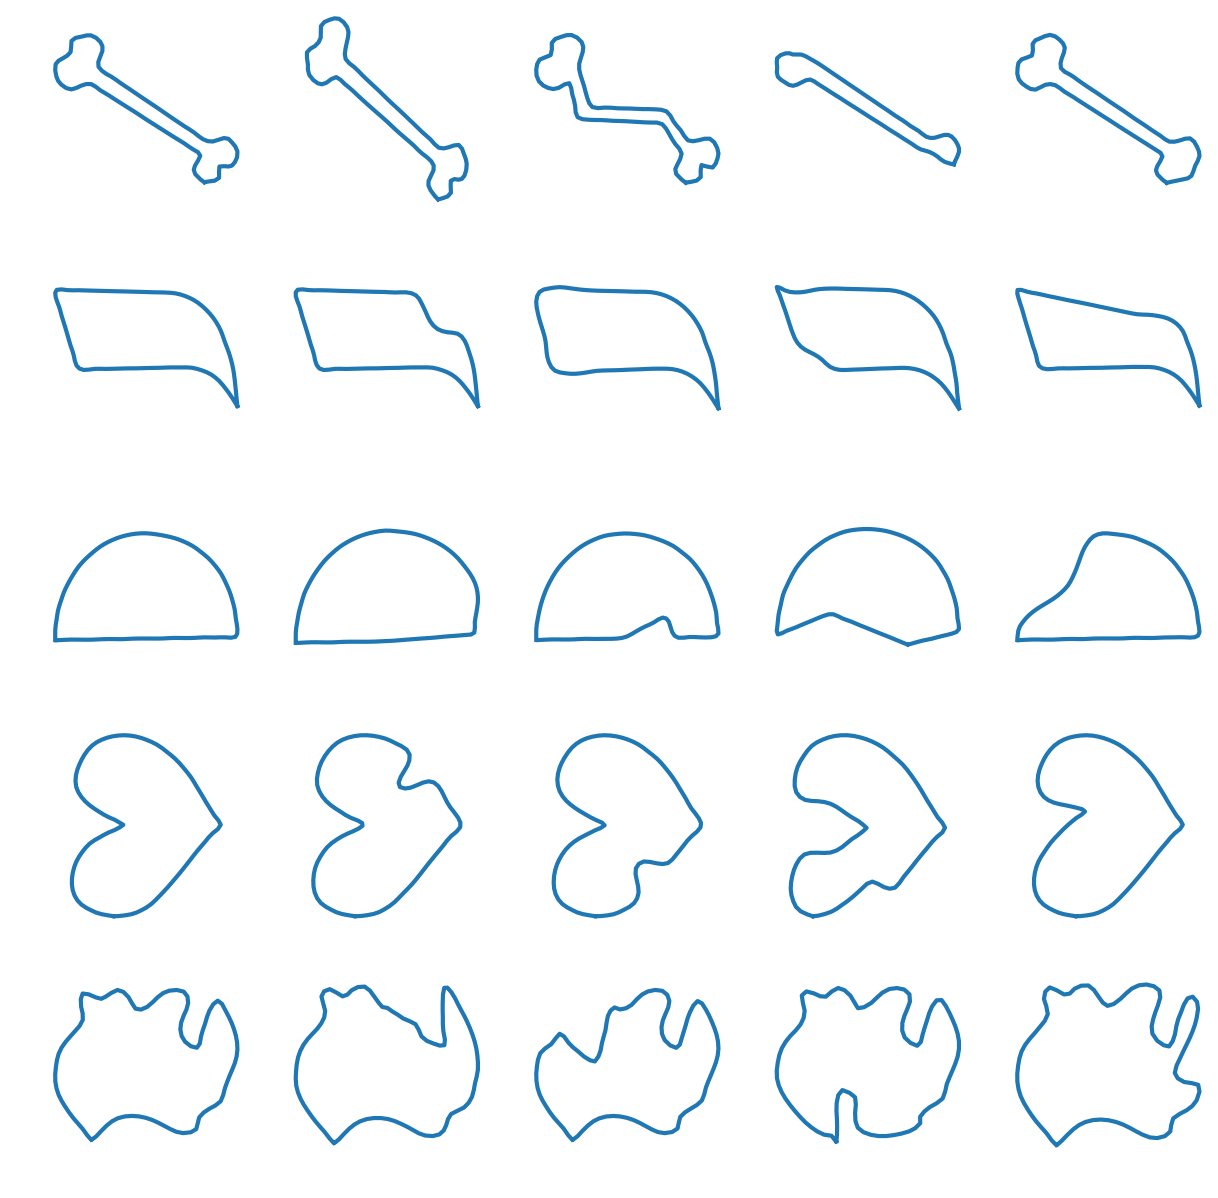

In [39]:
shape_indices = [4*x for x in range(25)]

fig = plt.figure(figsize = (15,15))

for j in range(25):
    ax = fig.add_subplot(5,5,j+1)
    shape = planarShapes[:,:,shape_indices[j]]
    ax.plot(shape[0,:], shape[1,:], linewidth=3)
    ax.axis('off')
    ax.axis('equal')

Приведенный выше код отображает фигуры в виде непрерывных кривых, но данные для каждой фигуры на самом деле являются облаком точек.

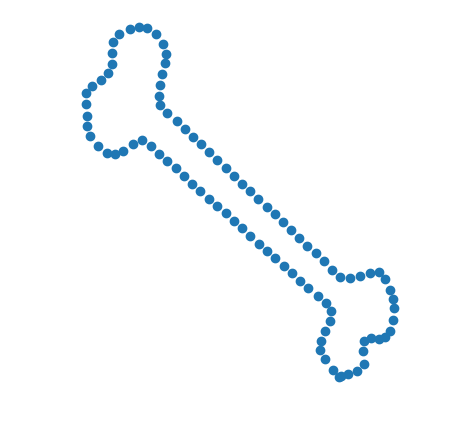

In [40]:
plt.figure(figsize=(5,5))
shape = planarShapes[:,:,4]
plt.scatter(shape[0,:], shape[1,:])
plt.axis('off')
plt.axis('equal');

## Initial Experiments with Bottleneck Distance

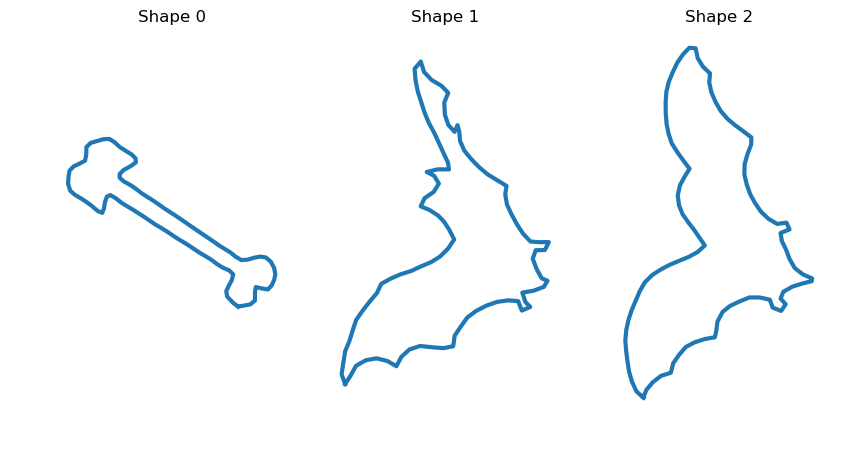

In [41]:
shape_indices = [1,125,127] # Выбор несколько фигур

num_shapes = len(shape_indices) 

fig = plt.figure(figsize = (10,5))

for j in range(num_shapes):
    ax = fig.add_subplot(1,3,j+1)
    shape = planarShapes[:,:,shape_indices[j]]
    ax.plot(shape[0,:], shape[1,:], linewidth=3)
    ax.axis('off')
    plt.title('Shape '+str(j))
    ax.axis('equal')

Вычислим persistence диаграммы для этих примеров, а затем посмотрим на расстояния между ними. Важно помнить, что `ripser` предпочитает транспонировать облака точек (то есть shape 1 задается как массив 2x100, но ripser хочет видеть массив 100x2).

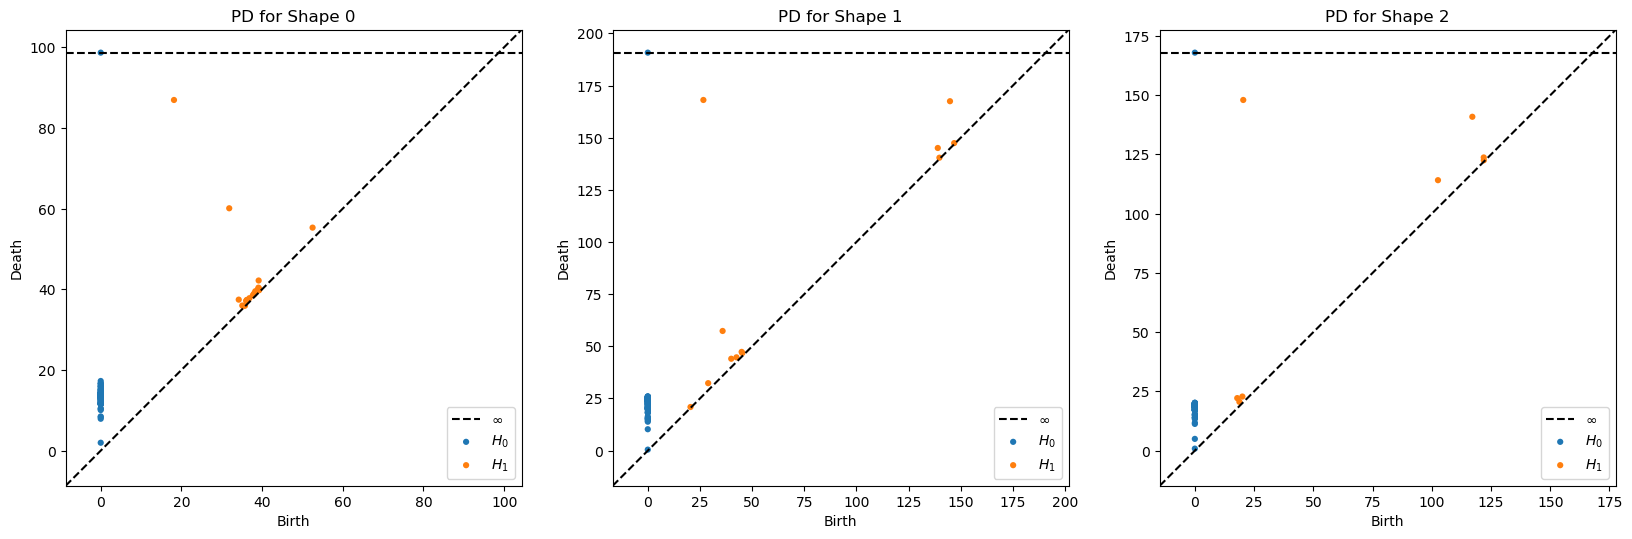

In [42]:
shapeDgms = [ripser(planarShapes[:,:,shape_indices[j]].T)['dgms'] for j in range(num_shapes)]

fig = plt.figure(figsize=(20,10))

for j in range(num_shapes):
    ax = fig.add_subplot(1,num_shapes,j+1) 
    plt.title('PD for Shape '+str(j))
    plot_diagrams(shapeDgms[j])

Пакет `persim` включает в себя некоторые метрики расстояний между диаграммами персистентности, включая **bottleneck** расстояние, которое мы определили в классе. Вычисляем **bottleneck distances** между нашими примерами. Существует возможность не только вычислить расстояние, но и записать оптимальное соответствие, которое его производит.

Вычисляем **bottleneck** расстояние между диаграммами персистентности степени 1 для фигур с индексами 0 и 1:

In [43]:
distance_bottleneck, (matching, D) = persim.bottleneck(shapeDgms[0][1], shapeDgms[1][1], matching=True)
print(distance_bottleneck)

70.71136951446533


Затем мы можем построить **persistence diagrams** на тех же осях и отобразить оптимальное соответствие. Сегмент зеленой линии показывает совпадающие точки, несущие наибольшую стоимость.

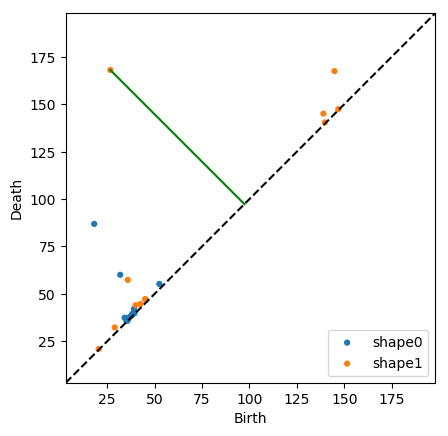

In [44]:
persim.bottleneck_matching(shapeDgms[0][1], shapeDgms[1][1], matching, D, labels=['shape0', 'shape1'])

Также вычислим расстояние между фигурами с индексами 0 и 2:

In [45]:
distance_bottleneck, (matching, D) = persim.bottleneck(shapeDgms[0][1], shapeDgms[2][1], matching=True)
print(distance_bottleneck)

61.09130859375


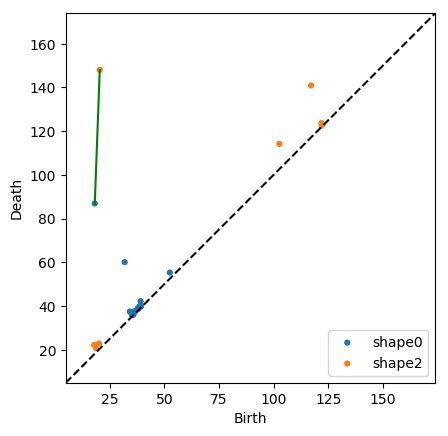

In [46]:
persim.bottleneck_matching(shapeDgms[0][1], shapeDgms[2][1], matching, D, labels=['shape0', 'shape2'])

Наконец, вычисляем расстояние между фигурами 1 и 2:

20.066848754882812


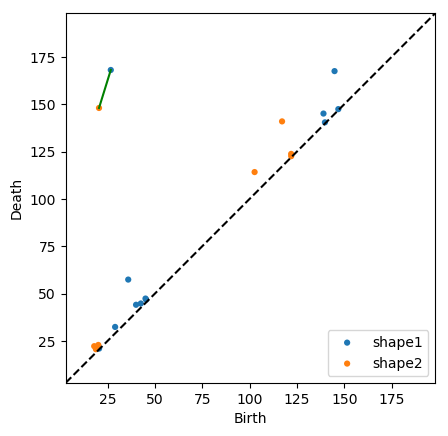

In [47]:
distance_bottleneck, (matching, D) = persim.bottleneck(shapeDgms[1][1], shapeDgms[2][1], matching=True)
print(distance_bottleneck)

persim.bottleneck_matching(shapeDgms[1][1], shapeDgms[2][1], matching, D, labels=['shape1', 'shape2'])

Мы можем суммировать расстояния, вычисляя матрицу расстояний. Поскольку мы сравниваем 3 фигуры, матрица расстояний будет матрицей 3 × 3, у которой (𝑖, 𝑗) - **bottleneck distance** между Shape 𝑖 и Shape 𝑗.

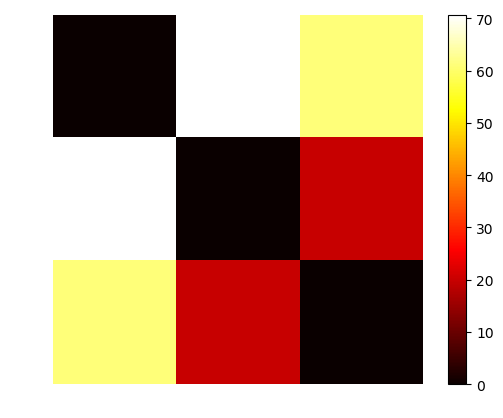

In [48]:
# Вычисляем матрицу расстояний
distMat = np.zeros((3,3))

for i in range(3):
    for j in range(3):
        distMat[i,j] = persim.bottleneck(shapeDgms[i][1], shapeDgms[j][1], matching=True)[0]
        
# Display the distance matrix
img = plt.imshow(distMat)
img.set_cmap('hot')
plt.colorbar()
plt.axis('off');

Использование таких библиотек как `ripser`, `persim`, а также стандартной библиотеки `sklearn`, в комплексе позволяет реализовать большее количество поставленных целей и достичь высоких результатов в работе с топологическим анализом данных.